In [2]:
import pandas as pd
ws = pd.read_csv('/content/LFRS_nantes.csv')
ws.head()

<ipython-input-2-e37bfaec08d8>:2: DtypeWarning: Columns (2,3,6) have mixed types. Specify dtype option on import or set low_memory=False.
  ws = pd.read_csv('/content/LFRS_nantes.csv')


,station,valid,tmpc,relh,drct,sknt,vsby,skyc1,skyc2,skyc3,skyl1,skyl2,skyl3,wxcodes,peak_wind_gust,metar
0,LFRS,2000-01-01 00:00,7.89,97.38,240.00,2.00,4.00,M,M,M,M,M,M,M,M,LFRS 010000Z AUTO 24002KT 4SM 08/08 A3027 RMK ...
1,LFRS,2000-01-01 01:00,7.39,97.37,250.00,4.00,M,M,M,M,M,M,M,M,M,LFRS 010100Z AUTO 25004KT 07/07 RMK 60000 SLP2...
2,LFRS,2000-01-01 02:00,7.50,97.38,260.00,4.00,M,M,M,M,M,M,M,M,M,LFRS 010200Z AUTO 26004KT 08/07 RMK 60000 SLP2...
3,LFRS,2000-01-01 03:00,8.00,100.00,250.00,2.00,3.00,M,M,M,M,M,M,M,M,LFRS 010300Z AUTO 25002KT 3SM 08/08 A3030 RMK ...
4,LFRS,2000-01-01 04:00,8.22,97.76,280.00,4.00,6.00,M,M,M,M,M,M,M,M,LFRS 010400Z AUTO 28004KT 6SM 08/08 A3030 RMK ...


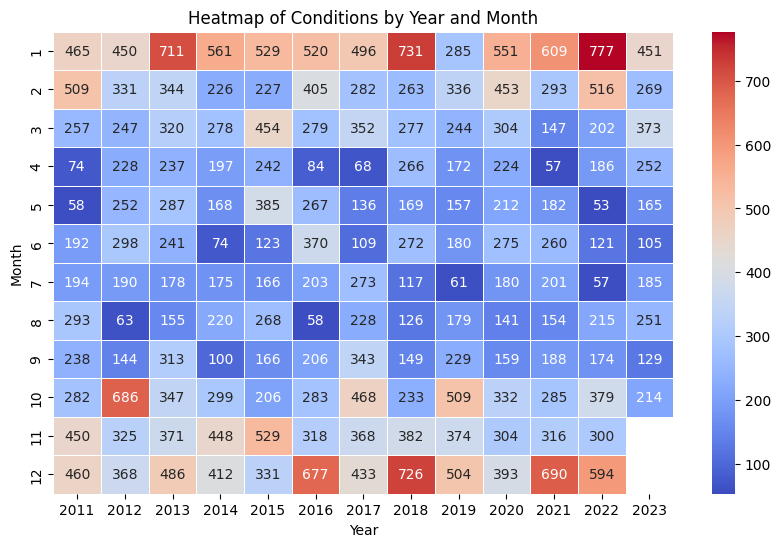

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Sample DataFrame 'm'

# m = reports[reports['year'] > 2010]

m = ws.copy()

m['valid'] = pd.to_datetime(m['valid'])

# Extract day month and hour from the 'valid' column
m['day'] = m['valid'].dt.date
m['hour'] = m['valid'].dt.hour
m['month'] = m['valid'].dt.month
m['year'] = m['valid'].dt.year

m = m[m['year'] > 2010]

m_processed = m[['year', 'month','tmpc', 'sknt', 'vsby', 'skyl1', 'wxcodes', 'peak_wind_gust']].copy()
m_processed = m_processed.apply(pd.to_numeric, errors='coerce')  # Convert non-numeric values to NaN

conditions = ((m_processed['tmpc'] < -10) | (m_processed['tmpc'] > 40) |
              (m_processed['sknt'] > 20) |
              (m_processed['vsby'] < 3) |
              (m_processed['skyl1'] < 1500) |
              (m_processed['wxcodes'].astype(str).str.contains('FG|TS|FZ', na=False)) |
              (m_processed['peak_wind_gust'] > 20))

m_processed['condition'] = np.where(conditions, 1, 0)

# Extract year and month from the 'valid' column


# Create a pivot table to aggregate conditions by year and month
heatmap_data = m_processed.pivot_table(index='month', columns='year', values='condition', aggfunc='sum')

# Create heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt='g', linewidths=0.5)

plt.title('Heatmap of Conditions by Year and Month')
plt.xlabel('Year')
plt.ylabel('Month')

plt.show()

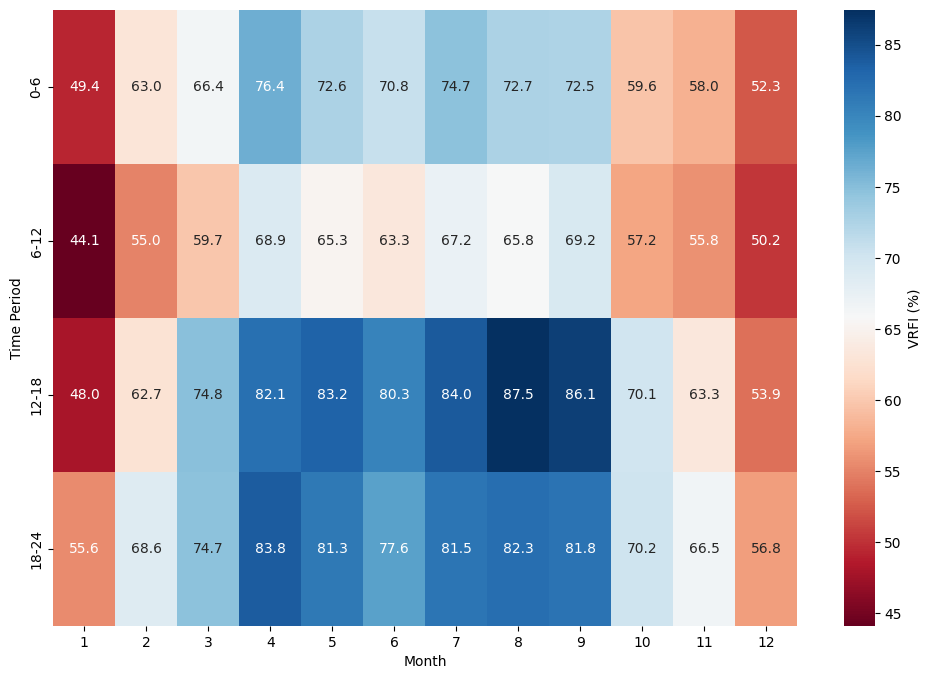

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'reports' is your DataFrame with the provided keys
m = ws.copy()

# Preprocessing to assign 1 to cells where at least one condition is true
m['valid'] = pd.to_datetime(m['valid'])

# Extract day, month, and hour from the 'valid' column
m['day'] = m['valid'].dt.date
m['hour'] = m['valid'].dt.hour
m['month'] = m['valid'].dt.month
m['year'] = m['valid'].dt.year

m = m[m['year'] > 2010]

m_processed = m[['year', 'month', 'hour', 'tmpc', 'sknt', 'vsby', 'skyl1', 'wxcodes', 'peak_wind_gust']].copy()
m_processed = m_processed.apply(pd.to_numeric, errors='coerce')  # Convert non-numeric values to NaN

# Define conditions
conditions = ((m_processed['tmpc'] < -10) | (m_processed['tmpc'] > 40) |
              (m_processed['sknt'] > 28) |
              (m_processed['vsby'] < 3) |
              (m_processed['skyl1'] < 2500) |
              (m_processed['wxcodes'].astype(str).str.contains('FG|TS|FZ', na=False)) |
              (m_processed['peak_wind_gust'] > 20))

#conditions = ((m_processed['skyl1'] < 2500))


m_processed['condition'] = np.where(conditions, 1, 0)

# Define time periods
def get_time_period(hour):
    if 0 <= hour < 6:
        return '0-6'
    elif 6 <= hour < 12:
        return '6-12'
    elif 12 <= hour < 18:
        return '12-18'
    else:
        return '18-24'

m_processed['time_period'] = m_processed['hour'].apply(get_time_period)

# Convert 'time_period' to a categorical type with the correct order
time_period_order = ['0-6', '6-12', '12-18', '18-24']
m_processed['time_period'] = pd.Categorical(m_processed['time_period'], categories=time_period_order, ordered=True)

# Group by month and time period to calculate the percentage of conditions met
grouped = m_processed.groupby(['month', 'time_period'])['condition'].mean().reset_index()
grouped['percentage'] = (1 - grouped['condition']) * 100

# Create a pivot table for the heatmap
pivot_table = grouped.pivot(index='time_period', columns='month', values='percentage')

# Plot the heatmap
fig, ax = plt.subplots(figsize=(12, 8))

sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap="RdBu", ax=ax, cbar_kws={'label': 'VRFI (%)'})

# Setting labels and title with correct units
ax.set_title('')
ax.set_xlabel('Month')
ax.set_ylabel('Time Period')

#plt.savefig('VRFI_drone2_2.png')
#plt.savefig('VRFI_drone2_2.pdf')

# Display the plot
plt.show()